In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from scipy.signal import spectrogram
from scipy.io import loadmat
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from scipy.signal import butter, filtfilt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [25]:
class TTTEEGBlock(nn.Module):
    def __init__(self, hidden_size, num_heads=4, head_dim=None, eta=0.001):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = head_dim if head_dim is not None else hidden_size // num_heads
        self.eta = eta
        
        self.W1 = nn.Parameter(torch.randn(num_heads, self.head_dim, self.head_dim) * 0.02)
        self.b1 = nn.Parameter(torch.zeros(num_heads, 1, self.head_dim))
        
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, cache_params=None):
        B, L, C = x.shape
        
        x = self.layer_norm(x)
        x = x.reshape(B, L, self.num_heads, self.head_dim)
        x = x.permute(0, 2, 1, 3)  # [B, H, L, D]
        
        if cache_params is None:
            output = self.dropout(torch.einsum('bhld,hdf->bhlf', x, self.W1) + self.b1.unsqueeze(0))
        else:
            with torch.enable_grad():
                x_temp = x.detach().requires_grad_()
                output_temp = torch.einsum('bhld,hdf->bhlf', x_temp, self.W1) + self.b1.unsqueeze(0)
                
                # Self-supervised loss: L2 loss + consistency loss
                l2_loss = output_temp.pow(2).mean()
                consistency_loss = torch.abs(output_temp - x_temp.mean(dim=-1, keepdim=True)).mean()
                self_supervised_loss = l2_loss + 0.1 * consistency_loss
                
                # Compute gradients for self-supervised loss
                grads = torch.autograd.grad(self_supervised_loss, [self.W1, self.b1], retain_graph=True, create_graph=False)
                grad_W1, grad_b1 = grads
                
                grad_W1 = torch.clamp(grad_W1, -1.0, 1.0)
                grad_b1 = torch.clamp(grad_b1, -1.0, 1.0)
                
                if f'W1_states_{id(self)}' not in cache_params:
                    cache_params[f'W1_states_{id(self)}'] = self.W1.clone()
                    cache_params[f'b1_states_{id(self)}'] = self.b1.clone()
                    cache_params[f'momentum_W1_{id(self)}'] = torch.zeros_like(self.W1)
                    cache_params[f'momentum_b1_{id(self)}'] = torch.zeros_like(self.b1)
                
                momentum = 0.9
                cache_params[f'momentum_W1_{id(self)}'] = (
                    momentum * cache_params[f'momentum_W1_{id(self)}'] + 
                    (1 - momentum) * grad_W1
                )
                cache_params[f'momentum_b1_{id(self)}'] = (
                    momentum * cache_params[f'momentum_b1_{id(self)}'] + 
                    (1 - momentum) * grad_b1
                )
                
                cache_params[f'W1_states_{id(self)}'] -= self.eta * cache_params[f'momentum_W1_{id(self)}']
                cache_params[f'b1_states_{id(self)}'] -= self.eta * cache_params[f'momentum_b1_{id(self)}']
                
                output = self.dropout(torch.einsum('bhld,hdf->bhlf', x, 
                                    cache_params[f'W1_states_{id(self)}']) + 
                                    cache_params[f'b1_states_{id(self)}'].unsqueeze(0))
        
        output = output.permute(0, 2, 1, 3)  # [B, L, H, D]
        output = output.reshape(B, L, -1)     # [B, L, H*D]
        
        return output + x.permute(0, 2, 1, 3).reshape(B, L, -1)  # Residual connection

In [26]:
# Load EEG data from .mat files
def load_mat_data(file_path):
    data = loadmat(file_path)['data'][0]
    inputs, targets = [], []
    map = {}
    current = 3
    for i in range(len(data)):
        y = data[i].flatten()
        sub = y[0][0]
        if y[1][0]=='letter-composing':
            continue
        if y[2][0] not in ['trial 1','trial 2','trial 3']:
            continue
        eeg_data = y[3][:6, :]
        if sub not in map:
            map[sub] = current
            current += 1
        targets.append(map[sub])
        inputs.append(eeg_data)
    return np.array(inputs), np.array(targets)

def preprocess_eeg(eeg_data):
    eeg_data = (eeg_data - np.mean(eeg_data)) / (np.std(eeg_data) + 1e-8)
    nyq = 0.5 * 256
    low, high = 0.5 / nyq, 45 / nyq
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, eeg_data)

# Load EEG data from folder structure
def load_folder_data(root_path, tasks=['baseline', 'counting', 'logical', 'rotation']):
    root = Path(root_path)
    X, y = [], []
    subjects = [d for d in root.iterdir() if d.is_dir() and d.name in ['eshwa', 'Giri', 'Nithish']]
    for subject_idx, subject in enumerate(subjects):
        for task in tasks:
            session_pattern = f"OpenBCISession_{subject.name.lower()}_{task}_*"
            sessions = list(subject.glob(session_pattern))
            for session in sessions:
                raw_files = list(session.glob("OpenBCI-RAW-*.txt"))
                for raw_file in raw_files:
                    eeg_data = load_eeg_data(raw_file)
                    if eeg_data is not None:
                        for i in range(6):
                            X.append(eeg_data[3750:6250, i])
                            y.append(subject_idx)
    return np.array(X), np.array(y)

# Data Augmentation Functions
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    factor = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], 1))
    return x * factor


def create_spectrogram(eeg_data, fs=256, target_area=2500, num_frequencies=50, num_times=50):   
    # Calculate the segment length (nperseg) based on the desired number of frequency bins
    # The formula for frequency bins is: number of bins = nperseg / 2 + 1
    required_nperseg = (num_frequencies - 1) * 2  # Desired frequency bins and corresponding nperseg

    # Ensure nperseg doesn't exceed the total signal length
    nperseg = min(required_nperseg, len(eeg_data))

    noverlap = nperseg // 2  # Overlap (half of segment length by default)

    # Compute the spectrogram
    frequencies, times, Sxx = spectrogram(
        eeg_data, fs=fs, window='hamming', nperseg=nperseg, noverlap=noverlap, detrend='constant', scaling='density'
    )

    # Ensure we get the expected number of frequency bins
    if Sxx.shape[0] < num_frequencies:
        print(f"Warning: Expected {num_frequencies} frequency bins, but got {Sxx.shape[0]}. Padding with zeros.")
        padding = num_frequencies - Sxx.shape[0]
        Sxx = np.pad(Sxx, ((0, padding), (0, 0)), mode='constant')
    elif Sxx.shape[0] > num_frequencies:
        # If the number of frequency bins is more than desired, truncate
        Sxx = Sxx[:num_frequencies, :]

    # Ensure the number of time bins matches the desired number
    if Sxx.shape[1] < num_times:
        padding = num_times - Sxx.shape[1]
        Sxx = np.pad(Sxx, ((0, 0), (0, padding)), mode='constant')
    elif Sxx.shape[1] > num_times:
        # Trim time bins if there are more than desired
        Sxx = Sxx[:, :num_times]

    # Convert to decibels
    Sxx = 10 * np.log10(Sxx + 1e-5)

    # Normalize the spectrogram
    Sxx = (Sxx - Sxx.min()) / (Sxx.max() - Sxx.min() + 1e-8)
    return Sxx

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

class TTTCell(nn.Module):
    def __init__(self, input_size, hidden_size, eta=0.001):
        super().__init__()
        self.hidden_size = hidden_size
        self.eta = eta
        
        # Hidden state model (f in the paper)
        self.hidden_model = nn.Sequential(
            nn.Linear(input_size, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),
            nn.GELU(),
            nn.Linear(hidden_size * 2, hidden_size)
        )
        
        # Initialize cache for test-time updates
        self.cache_params = {}
        
    def forward(self, x, hidden, is_training=True):
        if is_training:
            next_hidden = self.hidden_model(x)
        else:
            # Test-time training update
            with torch.enable_grad():
                x_temp = x.detach().requires_grad_()
                pred = self.hidden_model(x_temp)
                
                # Self-supervised loss (as described in paper section 2.1)
                l2_loss = pred.pow(2).mean()
                consistency_loss = torch.abs(pred - x_temp.mean(dim=-1, keepdim=True)).mean()
                loss = l2_loss + 0.1 * consistency_loss
                
                # Update hidden model parameters
                grads = torch.autograd.grad(loss, self.hidden_model.parameters())
                
                with torch.no_grad():
                    for param, grad in zip(self.hidden_model.parameters(), grads):
                        if f'momentum_{id(param)}' not in self.cache_params:
                            self.cache_params[f'momentum_{id(param)}'] = torch.zeros_like(param)
                        
                        # Momentum update
                        self.cache_params[f'momentum_{id(param)}'].mul_(0.9).add_(grad, alpha=0.1)
                        param.add_(self.cache_params[f'momentum_{id(param)}'], alpha=-self.eta)
                
                next_hidden = self.hidden_model(x)
                
        return next_hidden


class TTTRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Create TTT cells for each layer
        self.cells = nn.ModuleList([
            TTTCell(
                input_size if i == 0 else hidden_size,
                hidden_size
            ) for i in range(num_layers)
        ])
    
    def forward(self, x, hidden=None, is_training=True):
        batch_size, seq_len, _ = x.shape
        
        if hidden is None:
            hidden = [torch.zeros(batch_size, self.hidden_size).to(x.device)
                     for _ in range(self.num_layers)]
        
        outputs = []
        for t in range(seq_len):
            layer_input = x[:, t, :]
            for layer_idx, cell in enumerate(self.cells):
                hidden[layer_idx] = cell(layer_input, hidden[layer_idx], is_training)
                layer_input = hidden[layer_idx]
            outputs.append(layer_input)
            
        outputs = torch.stack(outputs, dim=1)
        return outputs, hidden


class EEGClassifier(nn.Module):
    def __init__(self, input_channels=1, num_classes=10, dropout_prob=0.5):
        super().__init__()
        self.cache_params = {}
        
        # Feature extractor
        self.feature_extractor = nn.Sequential(
            # Initial block
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 25x25
            
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 12x12
            
            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 6x6
            
            # Fourth block with global pooling
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling to 1x1
        )
        
        # TTT blocks
        self.ttt_blocks = nn.ModuleList([
            TTTEEGBlock(hidden_size=256, num_heads=4)
            for _ in range(2)
        ])
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(256, 512),  # Now using 256 features from global pooling
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, num_classes)
        )
        
        # Reconstruction decoder
        self.decoder = nn.Sequential(
            nn.Linear(256, 1024),  # From 256 features
            nn.ReLU(),
            nn.Linear(1024, 50 * 50)
        )
    
    def forward(self, x):
        # Print input shape for debugging
        # print("Input shape:", x.shape)
        
        # Ensure input shape [B, C, H, W]
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        
        # Extract features
        features = self.feature_extractor(x)  # [B, 256, 1, 1]
        # print("After feature extractor:", features.shape)
        
        # Reshape for TTT blocks
        features = features.squeeze(-1).squeeze(-1)  # [B, 256]
        features = features.unsqueeze(1)  # [B, 1, 256]
        
        # Apply TTT blocks
        for block in self.ttt_blocks:
            features = block(features, self.cache_params)
        
        # Prepare for classification
        features = features.squeeze(1)  # [B, 256]
        
        # Classification
        logits = self.classifier(features)
        
        # Reconstruction
        recon = self.decoder(features)
        recon = recon.view(-1, 1, 50, 50)
        
        return logits, recon
    
def SEBlock(channels):
    return nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(channels, channels, kernel_size=1),
        nn.Sigmoid()
    )


def ResidualBlock(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.GELU(),
        SEBlock(out_channels),
    )

In [28]:
# def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
#     optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
#     scheduler = optim.lr_scheduler.OneCycleLR(
#         optimizer,
#         max_lr=learning_rate,
#         epochs=num_epochs,
#         steps_per_epoch=len(train_loader)
#     )
#     criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
#     best_val_acc = 0
#     patience = 7
#     patience_counter = 0
    
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         correct = 0
#         total = 0
        
#         pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
#         for batch_idx, (inputs, labels) in enumerate(pbar):
#             inputs = inputs.float()
            
#             optimizer.zero_grad(set_to_none=True)
            
#             try:
#                 # Forward pass
#                 outputs, recon = model(inputs)
                
#                 # Calculate losses
#                 ce_loss = criterion(outputs, labels)
#                 recon_loss = F.mse_loss(recon, inputs)
#                 loss = ce_loss + 0.1 * recon_loss
                
#                 # Backward pass
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#                 optimizer.step()
#                 scheduler.step()
                
#                 # Update metrics
#                 running_loss += loss.item()
#                 _, predicted = outputs.max(1)
#                 total += labels.size(0)
#                 correct += predicted.eq(labels).sum().item()
                
#                 # Update progress bar
#                 accuracy = 100. * correct / total
#                 pbar.set_postfix({
#                     'loss': f'{running_loss/(batch_idx+1):.4f}',
#                     'acc': f'{accuracy:.2f}%'
#                 })
                
#             except RuntimeError as e:
#                 print(f"Error in batch {batch_idx}: {e}")
#                 print(f"Input shape: {inputs.shape}")
#                 raise e
        
#         # Validation phase
#         model.eval()
#         val_correct = 0
#         val_total = 0
#         val_loss = 0.0
        
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs = inputs.float()
#                 outputs, _ = model(inputs)
#                 _, predicted = outputs.max(1)
#                 val_total += labels.size(0)
#                 val_correct += predicted.eq(labels).sum().item()
        
#         val_accuracy = 100. * val_correct / val_total
#         print(f'\nValidation Accuracy: {val_accuracy:.2f}%')
        
#         # Early stopping
#         if val_accuracy > best_val_acc:
#             best_val_acc = val_accuracy
#             patience_counter = 0
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'val_acc': val_accuracy,
#             }, 'best_model.pth')
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print(f'Early stopping triggered. Best validation accuracy: {best_val_acc:.2f}%')
#                 checkpoint = torch.load('best_model.pth')
#                 model.load_state_dict(checkpoint['model_state_dict'])
#                 break
    
#     return model

# Test-time adaptation function
def test_time_adaptation(model, test_loader, adaptation_steps=5, adaptation_lr=0.001):
    model.eval()
    inner_optimizer = optim.SGD(model.inner_model.parameters(), lr=adaptation_lr)
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        for _ in range(adaptation_steps):
            inner_optimizer.zero_grad()
            _, recon = model(inputs)
            inputs = inputs.squeeze(2)
            recon_loss = nn.functional.mse_loss(recon, inputs)
            inputs = inputs.unsqueeze(2)
            recon_loss.backward()
            inner_optimizer.step()
    return model

In [43]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # 1. Reduce learning rate and add weight decay
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.0001,  # Reduced from 0.0003
        weight_decay=0.05,  # Increased from 0.01
        betas=(0.9, 0.999)
    )
    
    # 2. Modified learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=5,
        verbose=True
    )
    
    # 3. Enhanced loss function
    criterion = nn.CrossEntropyLoss(label_smoothing=0.2)  # Increased smoothing
    recon_criterion = nn.MSELoss()
    
    # 4. Add early stopping
    best_val_acc = 0
    patience = 15
    patience_counter = 0
    best_model_state = None
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        hidden = None
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 5. Mixup augmentation
            alpha = 0.2
            lam = np.random.beta(alpha, alpha)
            batch_size = inputs.size()[0]
            index = torch.randperm(batch_size).to(device)
            mixed_x = lam * inputs + (1 - lam) * inputs[index, :]
            target_a, target_b = targets, targets[index]
            
            optimizer.zero_grad()
            
            # Forward pass
            logits, recon, hidden = model(mixed_x, hidden)
            hidden = [h.detach() for h in hidden]
            
            # 6. Modified loss calculation with mixup
            ce_loss = lam * criterion(logits, target_a) + (1 - lam) * criterion(logits, target_b)
            recon_loss = recon_criterion(recon, inputs)
            loss = ce_loss + 0.05 * recon_loss  # Reduced reconstruction weight
            
            # Backward pass with gradient clipping
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Reduced from 1.0
            optimizer.step()
            
            # Update metrics
            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += targets.size(0)
            correct += (lam * predicted.eq(target_a).float() + (1 - lam) * predicted.eq(target_b).float()).sum().item()
        
        train_loss = total_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        hidden = None
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # 7. Test-time augmentation
                batch_size = inputs.size(0)
                tta_samples = 3
                tta_predictions = torch.zeros(batch_size, model.classifier[-1].out_features).to(device)
                
                for _ in range(tta_samples):
                    logits, _, _ = model(inputs, hidden)
                    tta_predictions += F.softmax(logits, dim=1)
                
                tta_predictions /= tta_samples
                
                loss = criterion(tta_predictions, targets)
                val_loss += loss.item()
                
                _, predicted = tta_predictions.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        
        # Update learning rate based on validation accuracy
        scheduler.step(val_acc)
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered at epoch {epoch}')
                model.load_state_dict(best_model_state)
                break
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    # 8. Return best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses, train_accs, val_accs


In [30]:
class EEGDataset(Dataset):
    def __init__(self, data, labels, augment=False):
        self.data = []
        self.labels = []
        
        for i, eeg in enumerate(tqdm(data, desc="Creating spectrograms")):
            for channel in range(eeg.shape[0]):
                spectrogram = create_spectrogram(preprocess_eeg(eeg[channel]))
                if augment:
                    specs = [
                        spectrogram,
                        jitter(spectrogram, sigma=0.01),
                        scaling(spectrogram, sigma=0.1),
                        add_noise(spectrogram, noise_level=0.01),
                        time_warp(spectrogram, sigma=2)
                    ]
                    for spec in specs:
                        self.data.append(spec)
                        self.labels.append(labels[i])
                else:
                    self.data.append(spectrogram)
                    self.labels.append(labels[i])
        
        self.data = torch.FloatTensor(np.stack(self.data))
        self.data = self.data.unsqueeze(1)
        self.labels = torch.LongTensor(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def add_noise(x, noise_level=0.01):
    return x + np.random.randn(*x.shape) * noise_level

def time_warp(x, sigma=2):
    """Apply time warping to a 2D spectrogram."""
    x = np.array(x)
    if len(x.shape) != 2:
        raise ValueError(f"Expected 2D input, got shape {x.shape}")
        
    time_steps = np.arange(x.shape[1])
    # Generate random warping
    warp = np.random.normal(loc=1.0, scale=sigma, size=(1,))
    warp_steps = time_steps * warp
    
    # Ensure warp_steps are within bounds
    warp_steps = np.clip(warp_steps, 0, x.shape[1]-1)
    
    # Apply warping to each frequency bin
    warped = np.zeros_like(x)
    for i in range(x.shape[0]):
        warped[i, :] = np.interp(time_steps, warp_steps, x[i, :])
    
    return warped

def jitter(x, sigma=0.01):
    """Add random jitter noise."""
    return x + np.random.normal(0, sigma, x.shape)

def scaling(x, sigma=0.1):
    """Apply random scaling."""
    factor = np.random.normal(1.0, sigma)
    return x * factor

In [31]:
def load_eeg_data(file_path):
    """Load EEG data from OpenBCI-RAW files"""
    try:
        # Skip header rows and load only first 6 EEG channels
        data = pd.read_csv(file_path, skiprows=6)
        eeg_data = data.iloc[:, 1:7].values
        return eeg_data
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None
def load_folder_data(root_path, tasks=['baseline', 'counting', 'logical', 'rotation']):
    root = Path(root_path)
    X, y = [], []
    subjects = [d for d in root.iterdir() if d.is_dir() and d.name in ['eshwa', 'Giri', 'Nithish']]
    
    for subject_idx, subject in enumerate(subjects):
        for task in tasks:
            session_pattern = f"OpenBCISession_{subject.name.lower()}_{task}_*"
            sessions = list(subject.glob(session_pattern))
            
            for session in sessions:
                raw_files = list(session.glob("OpenBCI-RAW-*.txt"))
                
                for raw_file in raw_files:
                    eeg_data = load_eeg_data(raw_file)
                    if eeg_data is not None:
                        # Ensure we have enough data to slice 2500 samples
                        if eeg_data.shape[0] >= 6250:
                            # Extract 2500 samples from each of the 6 channels
                            X.append(eeg_data[3750:6250, :6])
                            y.append(subject_idx)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Check if we have the desired number of samples
    if X.shape[0] != 36:
        print(f"Warning: Expected 36 samples, but got {X.shape[0]}")
    
    return X, y
    
mat_inputs, mat_targets = load_mat_data('eegdata.mat')
folder_inputs, folder_targets = load_folder_data('dataset')

# Ensure both datasets have the same number of dimensions
if mat_inputs.ndim == 3 and folder_inputs.ndim == 2:
    folder_inputs = folder_inputs[:, np.newaxis, :]  # Add a new axis to match dimensions

print(mat_inputs.shape,np.unique(mat_targets))

folder_inputs = folder_inputs.transpose(0, 2, 1)
print(folder_inputs.shape,np.unique(folder_targets))
X = np.concatenate((folder_inputs,mat_inputs), axis=0)
y = np.concatenate((folder_targets,mat_targets), axis=0)

# Print class and data shapes
print(f"Class shape: {y.shape}")
print(f"Data shape: {X.shape}")

# Prepare data loaders
dataset = EEGDataset(X, y, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


(84, 6, 2500) [3 4 5 6 7 8 9]
(36, 6, 2500) [0 1 2]
Class shape: (120,)
Data shape: (120, 6, 2500)


Creating spectrograms: 100%|██████████| 120/120 [00:01<00:00, 113.18it/s]


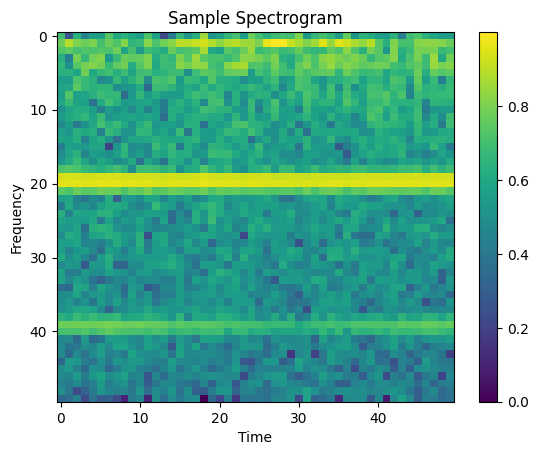

0


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [32]:
plt.imshow(create_spectrogram(X[0][0]), aspect='auto', cmap='viridis')
plt.title('Sample Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()
print(y[0])
y

In [ ]:
# Update dataset creation
dataset = EEGDataset(X, y, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Use smaller batch size for CPU
num_classes = len(np.unique(y))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=False)


In [39]:
# Update dataset creation
dataset = EEGDataset(X, y, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Use smaller batch size for CPU
num_classes = len(np.unique(y))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=False)

# Train with optimized parameters
model = EEGClassifier(
    input_channels=1,
    num_classes=num_classes,
    dropout_prob=0.5
)

trained_model = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    learning_rate=0.001
)

Epoch 1/50:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 90/90 [00:15<00:00,  5.92it/s, loss=0.0713, acc=15.87%]



Epoch 1/50:
Train Loss: 2.2816, Train Acc: 15.87%
Val Loss: 2.1164, Val Acc: 21.81%


Epoch 2/50: 100%|██████████| 90/90 [00:14<00:00,  6.11it/s, loss=0.0666, acc=21.60%]



Epoch 2/50:
Train Loss: 2.1320, Train Acc: 21.60%
Val Loss: 2.0027, Val Acc: 22.36%


Epoch 3/50: 100%|██████████| 90/90 [00:14<00:00,  6.06it/s, loss=0.0636, acc=23.61%]



Epoch 3/50:
Train Loss: 2.0355, Train Acc: 23.61%
Val Loss: 1.9254, Val Acc: 27.92%


Epoch 4/50: 100%|██████████| 90/90 [00:15<00:00,  5.86it/s, loss=0.0613, acc=27.29%]



Epoch 4/50:
Train Loss: 1.9630, Train Acc: 27.29%
Val Loss: 1.8701, Val Acc: 32.50%


Epoch 5/50:   1%|          | 1/90 [00:00<00:28,  3.11it/s, loss=0.0618, acc=18.75%]


KeyboardInterrupt: 

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

class TTTCell(nn.Module):
    def __init__(self, input_size, hidden_size, eta=0.001):
        super().__init__()
        self.hidden_size = hidden_size
        self.eta = eta
        
        # Hidden state model (f in the paper)
        self.hidden_model = nn.Sequential(
            nn.Linear(input_size, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),
            nn.GELU(),
            nn.Linear(hidden_size * 2, hidden_size)
        )
        
        # Initialize cache for test-time updates
        self.cache_params = {}
        
    def forward(self, x, hidden, is_training=True):
        if is_training:
            next_hidden = self.hidden_model(x)
        else:
            # Test-time training update
            with torch.enable_grad():
                x_temp = x.detach().requires_grad_()
                pred = self.hidden_model(x_temp)
                
                # Self-supervised loss (as described in paper section 2.1)
                l2_loss = pred.pow(2).mean()
                consistency_loss = torch.abs(pred - x_temp.mean(dim=-1, keepdim=True)).mean()
                loss = l2_loss + 0.1 * consistency_loss
                
                # Update hidden model parameters
                grads = torch.autograd.grad(loss, self.hidden_model.parameters())
                
                with torch.no_grad():
                    for param, grad in zip(self.hidden_model.parameters(), grads):
                        if f'momentum_{id(param)}' not in self.cache_params:
                            self.cache_params[f'momentum_{id(param)}'] = torch.zeros_like(param)
                        
                        # Momentum update
                        self.cache_params[f'momentum_{id(param)}'].mul_(0.9).add_(grad, alpha=0.1)
                        param.add_(self.cache_params[f'momentum_{id(param)}'], alpha=-self.eta)
                
                next_hidden = self.hidden_model(x)
                
        return next_hidden


class TTTRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Create TTT cells for each layer
        self.cells = nn.ModuleList([
            TTTCell(
                input_size if i == 0 else hidden_size,
                hidden_size
            ) for i in range(num_layers)
        ])
    
    def forward(self, x, hidden=None, is_training=True):
        batch_size, seq_len, _ = x.shape
        
        if hidden is None:
            hidden = [torch.zeros(batch_size, self.hidden_size).to(x.device)
                     for _ in range(self.num_layers)]
        
        outputs = []
        for t in range(seq_len):
            layer_input = x[:, t, :]
            for layer_idx, cell in enumerate(self.cells):
                hidden[layer_idx] = cell(layer_input, hidden[layer_idx], is_training)
                layer_input = hidden[layer_idx]
            outputs.append(layer_input)
            
        outputs = torch.stack(outputs, dim=1)
        return outputs, hidden


class EEGClassifier(nn.Module):
    def __init__(self, input_channels=1, num_classes=10, dropout_prob=0.5):
        super().__init__()
        self.cache_params = {}
        
        # Feature extractor
        self.feature_extractor = nn.Sequential(
            # Initial block
        #     nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),  # 25x25
        #     nn.Dropout(0.2),
            
        #     # Second block
        #     nn.Conv2d(32, 64, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),  # 12x12
        #     nn.Dropout(0.2),
            
        #     # Third block
        #     nn.Conv2d(64, 128, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),  # 6x6
        #     nn.Dropout(0.2),
            
        #     # Fourth block with global pooling
        #     nn.Conv2d(128, 256, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling to 1x1
        # )
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),  # Added dropout
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # TTT blocks
        self.ttt_blocks = nn.ModuleList([
            TTTEEGBlock(hidden_size=256, num_heads=4)
            for _ in range(2)
        ])
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(256, 512),  # Now using 256 features from global pooling
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, num_classes)
        )
        
        # Reconstruction decoder
        self.decoder = nn.Sequential(
            nn.Linear(256, 1024),  # From 256 features
            nn.ReLU(),
            nn.Linear(1024, 50 * 50)
        )
    
    def forward(self, x):
        # Print input shape for debugging
        # print("Input shape:", x.shape)
        
        # Ensure input shape [B, C, H, W]
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        
        # Extract features
        features = self.feature_extractor(x)  # [B, 256, 1, 1]
        # print("After feature extractor:", features.shape)
        
        # Reshape for TTT blocks
        features = features.squeeze(-1).squeeze(-1)  # [B, 256]
        features = features.unsqueeze(1)  # [B, 1, 256]
        
        # Apply TTT blocks
        for block in self.ttt_blocks:
            features = block(features, self.cache_params)
        
        # Prepare for classification
        features = features.squeeze(1)  # [B, 256]
        
        # Classification
        logits = self.classifier(features)
        
        # Reconstruction
        recon = self.decoder(features)
        recon = recon.view(-1, 1, 50, 50)
        
        return logits, recon
    
def SEBlock(channels):
    return nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(channels, channels, kernel_size=1),
        nn.Sigmoid()
    )


def ResidualBlock(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.GELU(),
        SEBlock(out_channels),
    )

In [42]:
model = EEGClassifier(
    input_channels=1,
    num_classes=num_classes,
    dropout_prob=0.3
)

trained_model, train_losses, val_losses, train_accs, val_accs = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=50
)

Epoch 1/50: 100%|██████████| 90/90 [00:21<00:00,  4.23it/s, loss=0.0604, acc=34.51%]



Epoch 1/50:
Train Loss: 1.9330, Train Acc: 34.51%
Val Loss: 1.7204, Val Acc: 45.69%


Epoch 2/50: 100%|██████████| 90/90 [00:20<00:00,  4.30it/s, loss=0.0493, acc=54.55%]



Epoch 2/50:
Train Loss: 1.5784, Train Acc: 54.55%
Val Loss: 1.4615, Val Acc: 58.75%


Epoch 3/50: 100%|██████████| 90/90 [00:20<00:00,  4.34it/s, loss=0.0409, acc=69.27%]



Epoch 3/50:
Train Loss: 1.3081, Train Acc: 69.27%
Val Loss: 1.2093, Val Acc: 76.81%


Epoch 4/50: 100%|██████████| 90/90 [00:20<00:00,  4.30it/s, loss=0.0345, acc=77.40%]



Epoch 4/50:
Train Loss: 1.1054, Train Acc: 77.40%
Val Loss: 1.1440, Val Acc: 71.94%


Epoch 5/50: 100%|██████████| 90/90 [00:20<00:00,  4.34it/s, loss=0.0291, acc=84.76%]



Epoch 5/50:
Train Loss: 0.9327, Train Acc: 84.76%
Val Loss: 0.9877, Val Acc: 82.36%


Epoch 6/50: 100%|██████████| 90/90 [00:20<00:00,  4.32it/s, loss=0.0251, acc=90.35%]



Epoch 6/50:
Train Loss: 0.8020, Train Acc: 90.35%
Val Loss: 0.9572, Val Acc: 84.31%


Epoch 7/50: 100%|██████████| 90/90 [00:21<00:00,  4.20it/s, loss=0.0229, acc=92.57%]



Epoch 7/50:
Train Loss: 0.7331, Train Acc: 92.57%
Val Loss: 1.2297, Val Acc: 63.61%


Epoch 8/50: 100%|██████████| 90/90 [00:21<00:00,  4.24it/s, loss=0.0218, acc=93.82%]



Epoch 8/50:
Train Loss: 0.6976, Train Acc: 93.82%
Val Loss: 1.0706, Val Acc: 74.44%


Epoch 9/50: 100%|██████████| 90/90 [00:21<00:00,  4.26it/s, loss=0.0209, acc=94.90%]



Epoch 9/50:
Train Loss: 0.6689, Train Acc: 94.90%
Val Loss: 1.3997, Val Acc: 58.06%


Epoch 10/50: 100%|██████████| 90/90 [00:21<00:00,  4.23it/s, loss=0.0206, acc=95.31%]



Epoch 10/50:
Train Loss: 0.6583, Train Acc: 95.31%
Val Loss: 0.9281, Val Acc: 87.08%


Epoch 11/50: 100%|██████████| 90/90 [00:21<00:00,  4.20it/s, loss=0.0200, acc=96.01%]



Epoch 11/50:
Train Loss: 0.6388, Train Acc: 96.01%
Val Loss: 1.3589, Val Acc: 61.53%


Epoch 12/50: 100%|██████████| 90/90 [00:21<00:00,  4.17it/s, loss=0.0194, acc=97.08%]



Epoch 12/50:
Train Loss: 0.6222, Train Acc: 97.08%
Val Loss: 1.4533, Val Acc: 56.25%


Epoch 13/50: 100%|██████████| 90/90 [00:21<00:00,  4.16it/s, loss=0.0190, acc=97.43%]



Epoch 13/50:
Train Loss: 0.6081, Train Acc: 97.43%
Val Loss: 1.1401, Val Acc: 75.56%


Epoch 14/50: 100%|██████████| 90/90 [00:22<00:00,  4.03it/s, loss=0.0187, acc=97.95%]



Epoch 14/50:
Train Loss: 0.5980, Train Acc: 97.95%
Val Loss: 1.3772, Val Acc: 62.78%


Epoch 15/50: 100%|██████████| 90/90 [00:23<00:00,  3.83it/s, loss=0.0181, acc=98.51%]



Epoch 15/50:
Train Loss: 0.5808, Train Acc: 98.51%
Val Loss: 1.5295, Val Acc: 62.22%


Epoch 16/50: 100%|██████████| 90/90 [00:23<00:00,  3.79it/s, loss=0.0177, acc=98.78%]



Epoch 16/50:
Train Loss: 0.5654, Train Acc: 98.78%
Val Loss: 1.0335, Val Acc: 81.25%


Epoch 17/50: 100%|██████████| 90/90 [00:22<00:00,  3.94it/s, loss=0.0175, acc=99.31%]



Epoch 17/50:
Train Loss: 0.5592, Train Acc: 99.31%
Val Loss: 1.3159, Val Acc: 64.03%


Epoch 18/50: 100%|██████████| 90/90 [00:23<00:00,  3.90it/s, loss=0.0174, acc=99.13%]



Epoch 18/50:
Train Loss: 0.5576, Train Acc: 99.13%
Val Loss: 0.8448, Val Acc: 90.83%


Epoch 19/50: 100%|██████████| 90/90 [00:24<00:00,  3.69it/s, loss=0.0171, acc=99.58%]



Epoch 19/50:
Train Loss: 0.5459, Train Acc: 99.58%
Val Loss: 1.1060, Val Acc: 74.44%


Epoch 20/50: 100%|██████████| 90/90 [00:24<00:00,  3.70it/s, loss=0.0167, acc=99.86%]



Epoch 20/50:
Train Loss: 0.5344, Train Acc: 99.86%
Val Loss: 0.8542, Val Acc: 88.33%


Epoch 21/50: 100%|██████████| 90/90 [00:23<00:00,  3.83it/s, loss=0.0168, acc=99.62%] 



Epoch 21/50:
Train Loss: 0.5383, Train Acc: 99.62%
Val Loss: 0.8157, Val Acc: 90.56%


Epoch 22/50: 100%|██████████| 90/90 [00:23<00:00,  3.84it/s, loss=0.0166, acc=99.83%] 



Epoch 22/50:
Train Loss: 0.5307, Train Acc: 99.83%
Val Loss: 0.9987, Val Acc: 79.31%


Epoch 23/50: 100%|██████████| 90/90 [00:23<00:00,  3.84it/s, loss=0.0165, acc=99.72%] 



Epoch 23/50:
Train Loss: 0.5289, Train Acc: 99.72%
Val Loss: 0.8207, Val Acc: 89.58%


Epoch 24/50: 100%|██████████| 90/90 [00:24<00:00,  3.72it/s, loss=0.0164, acc=99.93%]



Epoch 24/50:
Train Loss: 0.5239, Train Acc: 99.93%
Val Loss: 0.9683, Val Acc: 79.44%


Epoch 25/50: 100%|██████████| 90/90 [00:25<00:00,  3.57it/s, loss=0.0162, acc=99.97%] 



Epoch 25/50:
Train Loss: 0.5192, Train Acc: 99.97%
Val Loss: 0.7264, Val Acc: 91.94%


Epoch 26/50: 100%|██████████| 90/90 [00:26<00:00,  3.44it/s, loss=0.0162, acc=99.93%] 



Epoch 26/50:
Train Loss: 0.5179, Train Acc: 99.93%
Val Loss: 0.7609, Val Acc: 90.69%


Epoch 27/50:  47%|████▋     | 42/90 [00:12<00:14,  3.35it/s, loss=0.0162, acc=99.93%] 


KeyboardInterrupt: 

In [47]:
def train_model(model, train_loader, val_loader, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Initialize optimizer with conservative parameters
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.00005,  # Very conservative learning rate
        weight_decay=0.1,  # Strong regularization
        betas=(0.9, 0.999)
    )
    
    # Cosine annealing scheduler with warm restarts
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,  # Initial cycle length
        T_mult=2,  # Cycle length multiplier
        eta_min=1e-6  # Minimum learning rate
    )
    
    # Loss functions with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
    recon_criterion = nn.MSELoss()
    
    # Initialize EMA model
    ema = torch.optim.swa_utils.AveragedModel(model)
    
    # Initialize tracking variables
    best_val_acc = 0
    patience = 15  # Increased patience
    patience_counter = 0
    best_model_state = None
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    # Number of gradient accumulation steps
    num_accumulation_steps = 4
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        
        # Progress bar for training
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs = inputs.to(device).float()
            targets = targets.to(device)
            
            # Zero gradients at the start of accumulation
            if batch_idx % num_accumulation_steps == 0:
                optimizer.zero_grad(set_to_none=True)
            
            # Forward pass
            logits, recon = model(inputs)
            
            # Calculate losses
            ce_loss = criterion(logits, targets)
            recon_loss = recon_criterion(recon, inputs)
            loss = ce_loss + 0.05 * recon_loss  # Reduced reconstruction weight
            
            # Scale loss for gradient accumulation
            loss = loss / num_accumulation_steps
            loss.backward()
            
            # Update weights after accumulation steps
            if (batch_idx + 1) % num_accumulation_steps == 0:
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()
                scheduler.step()
                
                # Update EMA model
                ema.update_parameters(model)
            
            # Update metrics
            running_loss += loss.item() * num_accumulation_steps
            _, predicted = logits.max(1)
            running_total += targets.size(0)
            running_correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            current_loss = running_loss / (batch_idx + 1)
            current_acc = 100. * running_correct / running_total
            pbar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'acc': f'{current_acc:.2f}%'
            })
        
        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * running_correct / running_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            # Use EMA model for validation
            ema.eval()
            
            for inputs, targets in val_loader:
                inputs = inputs.to(device).float()
                targets = targets.to(device)
                
                # Test-time augmentation
                n_augmentations = 5
                predictions = []
                
                for _ in range(n_augmentations):
                    logits, recon = ema.module(inputs)
                    predictions.append(F.softmax(logits, dim=1))
                
                # Average predictions
                averaged_preds = torch.stack(predictions).mean(0)
                
                # Calculate loss with averaged predictions
                loss = criterion(averaged_preds.log(), targets)
                val_loss += loss.item()
                
                _, predicted = averaged_preds.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
        
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Print epoch results
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = ema.module.state_dict().copy()  # Save EMA model state
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                model.load_state_dict(best_model_state)
                break
    
    # Plot smooth training curves
    plt.figure(figsize=(15, 5))
    
    def smooth_curve(points, factor=0.8):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(smooth_curve(train_losses), label='Training Loss')
    plt.plot(smooth_curve(val_losses), label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(smooth_curve(train_accs), label='Training Accuracy')
    plt.plot(smooth_curve(val_accs), label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Load best model before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses, train_accs, val_accs

# Usage example:
model = EEGClassifier(
    input_channels=1,
    num_classes=num_classes,
    dropout_prob=0.3
)

# Create data loaders with consistent batch size
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

# Train the model
trained_model, train_losses, val_losses, train_accs, val_accs = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=50
)

Epoch 1/50:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s, loss=2.0868, acc=30.31%]



Epoch 1/50:
Train Loss: 2.0868, Train Acc: 30.31%
Val Loss: 2.0468, Val Acc: 35.23%


Epoch 2/50: 100%|██████████| 90/90 [00:35<00:00,  2.55it/s, loss=1.8928, acc=42.85%]



Epoch 2/50:
Train Loss: 1.8928, Train Acc: 42.85%
Val Loss: 1.9941, Val Acc: 33.66%


Epoch 3/50: 100%|██████████| 90/90 [00:34<00:00,  2.63it/s, loss=1.7796, acc=51.60%]



Epoch 3/50:
Train Loss: 1.7796, Train Acc: 51.60%
Val Loss: 1.9610, Val Acc: 31.53%


Epoch 4/50: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s, loss=1.7162, acc=56.01%]



Epoch 4/50:
Train Loss: 1.7162, Train Acc: 56.01%
Val Loss: 1.9582, Val Acc: 28.69%


Epoch 5/50: 100%|██████████| 90/90 [00:34<00:00,  2.62it/s, loss=1.6014, acc=65.28%]



Epoch 5/50:
Train Loss: 1.6014, Train Acc: 65.28%
Val Loss: 1.9754, Val Acc: 30.68%


Epoch 6/50: 100%|██████████| 90/90 [00:36<00:00,  2.48it/s, loss=1.5403, acc=69.06%]



Epoch 6/50:
Train Loss: 1.5403, Train Acc: 69.06%
Val Loss: 1.9364, Val Acc: 33.38%


Epoch 7/50: 100%|██████████| 90/90 [00:35<00:00,  2.56it/s, loss=1.5117, acc=71.39%]



Epoch 7/50:
Train Loss: 1.5117, Train Acc: 71.39%
Val Loss: 1.9031, Val Acc: 40.34%


Epoch 8/50: 100%|██████████| 90/90 [00:36<00:00,  2.45it/s, loss=1.4569, acc=74.13%]



Epoch 8/50:
Train Loss: 1.4569, Train Acc: 74.13%
Val Loss: 1.9155, Val Acc: 40.34%


Epoch 9/50: 100%|██████████| 90/90 [00:36<00:00,  2.50it/s, loss=1.3854, acc=77.57%]



Epoch 9/50:
Train Loss: 1.3854, Train Acc: 77.57%
Val Loss: 1.9264, Val Acc: 42.90%


Epoch 10/50: 100%|██████████| 90/90 [00:38<00:00,  2.34it/s, loss=1.3325, acc=80.97%]



Epoch 10/50:
Train Loss: 1.3325, Train Acc: 80.97%
Val Loss: 1.8832, Val Acc: 50.14%


Epoch 11/50: 100%|██████████| 90/90 [00:35<00:00,  2.52it/s, loss=1.2872, acc=84.06%]



Epoch 11/50:
Train Loss: 1.2872, Train Acc: 84.06%
Val Loss: 1.8701, Val Acc: 45.88%


Epoch 12/50: 100%|██████████| 90/90 [00:35<00:00,  2.50it/s, loss=1.2744, acc=84.17%]



Epoch 12/50:
Train Loss: 1.2744, Train Acc: 84.17%
Val Loss: 1.8438, Val Acc: 51.99%


Epoch 13/50: 100%|██████████| 90/90 [00:38<00:00,  2.35it/s, loss=1.2551, acc=85.66%]



Epoch 13/50:
Train Loss: 1.2551, Train Acc: 85.66%
Val Loss: 1.8197, Val Acc: 55.11%


Epoch 14/50: 100%|██████████| 90/90 [00:38<00:00,  2.33it/s, loss=1.2438, acc=86.25%]



Epoch 14/50:
Train Loss: 1.2438, Train Acc: 86.25%
Val Loss: 1.7764, Val Acc: 57.39%


Epoch 15/50: 100%|██████████| 90/90 [00:36<00:00,  2.43it/s, loss=1.2382, acc=86.53%]



Epoch 15/50:
Train Loss: 1.2382, Train Acc: 86.53%
Val Loss: 1.7913, Val Acc: 52.98%


Epoch 16/50: 100%|██████████| 90/90 [00:36<00:00,  2.45it/s, loss=1.2000, acc=87.99%]



Epoch 16/50:
Train Loss: 1.2000, Train Acc: 87.99%
Val Loss: 1.7763, Val Acc: 57.67%


Epoch 17/50: 100%|██████████| 90/90 [00:36<00:00,  2.44it/s, loss=1.1617, acc=89.86%]



Epoch 17/50:
Train Loss: 1.1617, Train Acc: 89.86%
Val Loss: 1.7906, Val Acc: 52.84%


Epoch 18/50: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=1.1306, acc=90.83%]



Epoch 18/50:
Train Loss: 1.1306, Train Acc: 90.83%
Val Loss: 1.8061, Val Acc: 49.86%


Epoch 19/50: 100%|██████████| 90/90 [00:37<00:00,  2.37it/s, loss=1.1048, acc=92.57%]



Epoch 19/50:
Train Loss: 1.1048, Train Acc: 92.57%
Val Loss: 1.7859, Val Acc: 51.99%


Epoch 20/50: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s, loss=1.0851, acc=93.61%]



Epoch 20/50:
Train Loss: 1.0851, Train Acc: 93.61%
Val Loss: 1.7645, Val Acc: 55.68%


Epoch 21/50: 100%|██████████| 90/90 [00:40<00:00,  2.23it/s, loss=1.0706, acc=93.68%]



Epoch 21/50:
Train Loss: 1.0706, Train Acc: 93.68%
Val Loss: 1.7615, Val Acc: 55.26%


Epoch 22/50: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s, loss=1.0530, acc=94.62%]



Epoch 22/50:
Train Loss: 1.0530, Train Acc: 94.62%
Val Loss: 1.7432, Val Acc: 53.27%


Epoch 23/50: 100%|██████████| 90/90 [00:40<00:00,  2.25it/s, loss=1.0455, acc=95.35%]



Epoch 23/50:
Train Loss: 1.0455, Train Acc: 95.35%
Val Loss: 1.7372, Val Acc: 55.82%


Epoch 24/50: 100%|██████████| 90/90 [00:40<00:00,  2.22it/s, loss=1.0380, acc=94.93%]



Epoch 24/50:
Train Loss: 1.0380, Train Acc: 94.93%
Val Loss: 1.7057, Val Acc: 59.09%


Epoch 25/50: 100%|██████████| 90/90 [00:40<00:00,  2.23it/s, loss=1.0305, acc=95.80%]



Epoch 25/50:
Train Loss: 1.0305, Train Acc: 95.80%
Val Loss: 1.7009, Val Acc: 59.23%


Epoch 26/50: 100%|██████████| 90/90 [00:39<00:00,  2.27it/s, loss=1.0265, acc=95.52%]



Epoch 26/50:
Train Loss: 1.0265, Train Acc: 95.52%
Val Loss: 1.6533, Val Acc: 64.91%


Epoch 27/50: 100%|██████████| 90/90 [00:40<00:00,  2.24it/s, loss=1.0253, acc=95.62%]



Epoch 27/50:
Train Loss: 1.0253, Train Acc: 95.62%
Val Loss: 1.6428, Val Acc: 64.20%


Epoch 28/50: 100%|██████████| 90/90 [00:40<00:00,  2.23it/s, loss=1.0235, acc=96.04%]



Epoch 28/50:
Train Loss: 1.0235, Train Acc: 96.04%
Val Loss: 1.6196, Val Acc: 65.62%


Epoch 29/50: 100%|██████████| 90/90 [00:40<00:00,  2.20it/s, loss=1.0242, acc=95.80%]



Epoch 29/50:
Train Loss: 1.0242, Train Acc: 95.80%
Val Loss: 1.5963, Val Acc: 70.60%


Epoch 30/50: 100%|██████████| 90/90 [00:40<00:00,  2.20it/s, loss=1.0212, acc=95.83%]



Epoch 30/50:
Train Loss: 1.0212, Train Acc: 95.83%
Val Loss: 1.6165, Val Acc: 65.34%


Epoch 31/50: 100%|██████████| 90/90 [00:43<00:00,  2.06it/s, loss=1.0149, acc=95.97%]



Epoch 31/50:
Train Loss: 1.0149, Train Acc: 95.97%
Val Loss: 1.6545, Val Acc: 62.50%


Epoch 32/50: 100%|██████████| 90/90 [00:43<00:00,  2.08it/s, loss=1.0006, acc=96.60%]



Epoch 32/50:
Train Loss: 1.0006, Train Acc: 96.60%
Val Loss: 1.5518, Val Acc: 80.68%


Epoch 33/50: 100%|██████████| 90/90 [00:43<00:00,  2.08it/s, loss=0.9904, acc=97.01%]



Epoch 33/50:
Train Loss: 0.9904, Train Acc: 97.01%
Val Loss: 1.6021, Val Acc: 69.46%


Epoch 34/50: 100%|██████████| 90/90 [00:42<00:00,  2.11it/s, loss=0.9830, acc=97.22%]


KeyboardInterrupt: 

In [50]:
import math
class TTTEEGBlock(nn.Module):
    def __init__(self, hidden_size, num_heads=4, head_dim=None, eta=0.001):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = head_dim if head_dim is not None else hidden_size // num_heads
        self.eta = eta
        
        # Initialize with smaller values for stability
        self.W1 = nn.Parameter(torch.randn(num_heads, self.head_dim, self.head_dim) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(num_heads, 1, self.head_dim))
        
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.1)
        
        # Add skip connection scaling
        self.skip_scale = nn.Parameter(torch.ones(1))
        
    def forward(self, x, cache_params=None):
        B, L, C = x.shape
        residual = x
        
        x = self.layer_norm(x)
        x = x.reshape(B, L, self.num_heads, self.head_dim)
        x = x.permute(0, 2, 1, 3)  # [B, H, L, D]
        
        if cache_params is None:
            output = self.dropout(torch.einsum('bhld,hdf->bhlf', x, self.W1) + self.b1.unsqueeze(0))
        else:
            with torch.enable_grad():
                x_temp = x.detach().requires_grad_()
                output_temp = torch.einsum('bhld,hdf->bhlf', x_temp, self.W1) + self.b1.unsqueeze(0)
                
                # Modified self-supervised loss
                l2_loss = 0.5 * output_temp.pow(2).mean()
                consistency_loss = F.smooth_l1_loss(
                    output_temp, 
                    x_temp.mean(dim=-1, keepdim=True),
                    beta=0.1
                )
                self_supervised_loss = l2_loss + 0.05 * consistency_loss
                
                # Compute and stabilize gradients
                grads = torch.autograd.grad(self_supervised_loss, [self.W1, self.b1], 
                                         retain_graph=True, create_graph=False)
                grad_W1, grad_b1 = grads
                
                # Gradient clipping with dynamic threshold
                max_norm = 0.1 * (1.0 - math.exp(-len(cache_params) / 100))
                grad_W1 = torch.clamp(grad_W1, -max_norm, max_norm)
                grad_b1 = torch.clamp(grad_b1, -max_norm, max_norm)
                
                if f'W1_states_{id(self)}' not in cache_params:
                    cache_params[f'W1_states_{id(self)}'] = self.W1.clone()
                    cache_params[f'b1_states_{id(self)}'] = self.b1.clone()
                    cache_params[f'momentum_W1_{id(self)}'] = torch.zeros_like(self.W1)
                    cache_params[f'momentum_b1_{id(self)}'] = torch.zeros_like(self.b1)
                
                # Adaptive momentum
                beta1 = min(0.9, 1.0 - math.exp(-len(cache_params) / 50))
                cache_params[f'momentum_W1_{id(self)}'] = (
                    beta1 * cache_params[f'momentum_W1_{id(self)}'] + 
                    (1 - beta1) * grad_W1
                )
                cache_params[f'momentum_b1_{id(self)}'] = (
                    beta1 * cache_params[f'momentum_b1_{id(self)}'] + 
                    (1 - beta1) * grad_b1
                )
                
                # Adaptive learning rate
                lr_scale = math.exp(-len(cache_params) / 200)
                cache_params[f'W1_states_{id(self)}'] -= self.eta * lr_scale * cache_params[f'momentum_W1_{id(self)}']
                cache_params[f'b1_states_{id(self)}'] -= self.eta * lr_scale * cache_params[f'momentum_b1_{id(self)}']
                
                output = self.dropout(torch.einsum('bhld,hdf->bhlf', x, 
                                    cache_params[f'W1_states_{id(self)}']) + 
                                    cache_params[f'b1_states_{id(self)}'].unsqueeze(0))
        
        output = output.permute(0, 2, 1, 3)  # [B, L, H, D]
        output = output.reshape(B, L, -1)     # [B, L, H*D]
        
        # Scaled skip connection
        return output + self.skip_scale * residual

In [51]:
# Initialize model (keeping your original architecture)
model = EEGClassifier(
    input_channels=1,
    num_classes=num_classes,
    dropout_prob=0.3
)

# Train with smaller batch size
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

# Train model
trained_model, train_losses, val_losses, train_accs, val_accs = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=50
)

Epoch 1/50:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\eshwa\AppData\Local\Temp\ipykernel_24264\1028220634.py:37: UserWarning: Using a target size (torch.Size([32, 4, 1, 1])) that is different to the input size (torch.Size([32, 4, 1, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  consistency_loss = F.smooth_l1_loss(
Epoch 1/50: 100%|██████████| 90/90 [00:34<00:00,  2.61it/s, loss=2.2575, acc=20.56%]



Epoch 1/50:
Train Loss: 2.2575, Train Acc: 20.56%
Val Loss: 2.2315, Val Acc: 25.00%


Epoch 2/50: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s, loss=2.1754, acc=28.65%]



Epoch 2/50:
Train Loss: 2.1754, Train Acc: 28.65%
Val Loss: 2.2114, Val Acc: 23.58%


Epoch 3/50: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s, loss=2.0979, acc=32.12%]



Epoch 3/50:
Train Loss: 2.0979, Train Acc: 32.12%
Val Loss: 2.1846, Val Acc: 26.99%


Epoch 4/50: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s, loss=2.0493, acc=34.76%]



Epoch 4/50:
Train Loss: 2.0493, Train Acc: 34.76%
Val Loss: 2.1699, Val Acc: 27.56%


Epoch 5/50: 100%|██████████| 90/90 [00:34<00:00,  2.64it/s, loss=1.9746, acc=39.55%]



Epoch 5/50:
Train Loss: 1.9746, Train Acc: 39.55%
Val Loss: 2.1418, Val Acc: 29.26%


Epoch 6/50: 100%|██████████| 90/90 [00:34<00:00,  2.60it/s, loss=1.9362, acc=43.23%]



Epoch 6/50:
Train Loss: 1.9362, Train Acc: 43.23%
Val Loss: 2.1122, Val Acc: 29.12%


Epoch 7/50: 100%|██████████| 90/90 [00:34<00:00,  2.58it/s, loss=1.9261, acc=43.85%]



Epoch 7/50:
Train Loss: 1.9261, Train Acc: 43.85%
Val Loss: 2.0914, Val Acc: 30.26%


Epoch 8/50: 100%|██████████| 90/90 [00:41<00:00,  2.18it/s, loss=1.8825, acc=47.36%]



Epoch 8/50:
Train Loss: 1.8825, Train Acc: 47.36%
Val Loss: 2.0805, Val Acc: 23.86%


Epoch 9/50: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s, loss=1.8243, acc=51.81%]



Epoch 9/50:
Train Loss: 1.8243, Train Acc: 51.81%
Val Loss: 2.0650, Val Acc: 21.31%


Epoch 10/50: 100%|██████████| 90/90 [00:38<00:00,  2.36it/s, loss=1.7759, acc=55.38%]



Epoch 10/50:
Train Loss: 1.7759, Train Acc: 55.38%
Val Loss: 2.0580, Val Acc: 20.60%


Epoch 11/50: 100%|██████████| 90/90 [00:37<00:00,  2.38it/s, loss=1.7370, acc=56.63%]



Epoch 11/50:
Train Loss: 1.7370, Train Acc: 56.63%
Val Loss: 2.0385, Val Acc: 20.31%


Epoch 12/50: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s, loss=1.7126, acc=59.10%]



Epoch 12/50:
Train Loss: 1.7126, Train Acc: 59.10%
Val Loss: 2.0233, Val Acc: 21.45%


Epoch 13/50: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s, loss=1.6987, acc=60.45%]



Epoch 13/50:
Train Loss: 1.6987, Train Acc: 60.45%
Val Loss: 2.0096, Val Acc: 22.30%


Epoch 14/50: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=1.6940, acc=59.72%]



Epoch 14/50:
Train Loss: 1.6940, Train Acc: 59.72%
Val Loss: 1.9907, Val Acc: 24.57%


Epoch 15/50: 100%|██████████| 90/90 [00:37<00:00,  2.40it/s, loss=1.6811, acc=58.96%]



Epoch 15/50:
Train Loss: 1.6811, Train Acc: 58.96%
Val Loss: 1.9575, Val Acc: 29.55%


Epoch 16/50: 100%|██████████| 90/90 [00:37<00:00,  2.38it/s, loss=1.6319, acc=61.84%]



Epoch 16/50:
Train Loss: 1.6319, Train Acc: 61.84%
Val Loss: 1.9619, Val Acc: 27.98%


Epoch 17/50: 100%|██████████| 90/90 [00:38<00:00,  2.35it/s, loss=1.5932, acc=63.44%]



Epoch 17/50:
Train Loss: 1.5932, Train Acc: 63.44%
Val Loss: 1.9424, Val Acc: 30.26%


Epoch 18/50: 100%|██████████| 90/90 [00:37<00:00,  2.37it/s, loss=1.5499, acc=66.77%]



Epoch 18/50:
Train Loss: 1.5499, Train Acc: 66.77%
Val Loss: 1.9475, Val Acc: 30.40%


Epoch 19/50: 100%|██████████| 90/90 [00:39<00:00,  2.31it/s, loss=1.5201, acc=68.99%]



Epoch 19/50:
Train Loss: 1.5201, Train Acc: 68.99%
Val Loss: 1.9293, Val Acc: 33.52%


Epoch 20/50: 100%|██████████| 90/90 [00:38<00:00,  2.33it/s, loss=1.4912, acc=71.88%]



Epoch 20/50:
Train Loss: 1.4912, Train Acc: 71.88%
Val Loss: 1.8943, Val Acc: 39.06%


Epoch 21/50: 100%|██████████| 90/90 [00:39<00:00,  2.27it/s, loss=1.4701, acc=71.56%]



Epoch 21/50:
Train Loss: 1.4701, Train Acc: 71.56%
Val Loss: 1.8690, Val Acc: 41.05%


Epoch 22/50: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s, loss=1.4519, acc=74.38%]



Epoch 22/50:
Train Loss: 1.4519, Train Acc: 74.38%
Val Loss: 1.8534, Val Acc: 41.90%


Epoch 23/50: 100%|██████████| 90/90 [00:40<00:00,  2.24it/s, loss=1.4435, acc=75.14%]



Epoch 23/50:
Train Loss: 1.4435, Train Acc: 75.14%
Val Loss: 1.8470, Val Acc: 42.05%


Epoch 24/50: 100%|██████████| 90/90 [00:38<00:00,  2.32it/s, loss=1.4273, acc=75.97%]



Epoch 24/50:
Train Loss: 1.4273, Train Acc: 75.97%
Val Loss: 1.8355, Val Acc: 42.19%


Epoch 25/50: 100%|██████████| 90/90 [00:40<00:00,  2.22it/s, loss=1.4211, acc=76.15%]



Epoch 25/50:
Train Loss: 1.4211, Train Acc: 76.15%
Val Loss: 1.8127, Val Acc: 46.16%


Epoch 26/50:  44%|████▍     | 40/90 [00:18<00:23,  2.14it/s, loss=1.4323, acc=74.69%]


KeyboardInterrupt: 

In [54]:
def train_model(model, train_loader, val_loader, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # 1. Stable optimizer with very conservative settings
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.0001,  # Ultra-low learning rate for stability
        weight_decay=0.01,  # Moderate weight decay
        betas=(0.9, 0.999),  # Higher beta2 for momentum stability
        eps=1e-8
    )
    
    # 2. Gradual warm-up scheduler
    def lr_lambda(epoch):
        warmup_epochs = 5
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        return 0.5 ** ((epoch - warmup_epochs) // 10)
    
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    # 3. Loss functions with stability focus
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # Reduced smoothing
    recon_criterion = nn.SmoothL1Loss(beta=0.5)  # Higher beta for stability
    
    # 4. Initialize validation tracking
    best_val_acc = 0
    best_model_state = None
    validation_window = []  # For smoothed validation accuracy
    window_size = 3
    
    # 5. Training metrics
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        # Progress bar
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Clear gradients
            optimizer.zero_grad(set_to_none=True)
            
            # Forward pass
            logits, recon = model(inputs)
            
            # Calculate losses with stability focus
            ce_loss = criterion(logits, targets)
            recon_loss = recon_criterion(recon, inputs)
            loss = ce_loss + 0.01 * recon_loss  # Reduced reconstruction weight
            
            # Backward pass with gradient clipping
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)  # Conservative clipping
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            _, predicted = logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Validation phase with stability measures
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        predictions = []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Multiple forward passes for stability
                n_forwards = 3
                batch_preds = []
                
                for _ in range(n_forwards):
                    logits, recon = model(inputs)
                    batch_preds.append(F.softmax(logits, dim=1))
                
                # Average predictions
                avg_preds = torch.stack(batch_preds).mean(0)
                loss = criterion(avg_preds.log(), targets)
                
                val_loss += loss.item()
                _, predicted = avg_preds.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
                predictions.extend(predicted.cpu().numpy())
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        
        # Smooth validation accuracy
        validation_window.append(val_acc)
        if len(validation_window) > window_size:
            validation_window.pop(0)
        smoothed_val_acc = sum(validation_window) / len(validation_window)
        
        # Update learning rate
        scheduler.step()
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(smoothed_val_acc)  # Store smoothed validation accuracy
        
        # Save best model based on smoothed validation accuracy
        if smoothed_val_acc > best_val_acc:
            best_val_acc = smoothed_val_acc
            best_model_state = model.state_dict().copy()
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {smoothed_val_acc:.2f}%')
    
    # Plot smooth training curves
    plt.figure(figsize=(15, 5))
    
    def smooth_curve(points, factor=0.9):  # Increased smoothing factor
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(smooth_curve(train_losses), label='Training Loss')
    plt.plot(smooth_curve(val_losses), label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(smooth_curve(train_accs), label='Training Accuracy')
    plt.plot(smooth_curve(val_accs), label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Load best model before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses, train_accs, val_accs

Epoch 1/50:   0%|          | 0/180 [00:00<?, ?it/s]C:\Users\eshwa\AppData\Local\Temp\ipykernel_24264\1028220634.py:37: UserWarning: Using a target size (torch.Size([16, 4, 1, 1])) that is different to the input size (torch.Size([16, 4, 1, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  consistency_loss = F.smooth_l1_loss(
Epoch 1/50: 100%|██████████| 180/180 [00:43<00:00,  4.10it/s, loss=2.3186, acc=10.28%]



Epoch 1/50:
Train Loss: 2.3142, Train Acc: 10.28%
Val Loss: 2.3101, Val Acc: 10.83%


Epoch 2/50: 100%|██████████| 180/180 [00:47<00:00,  3.79it/s, loss=2.2987, acc=10.66%]



Epoch 2/50:
Train Loss: 2.3000, Train Acc: 10.66%
Val Loss: 2.2813, Val Acc: 10.76%


Epoch 3/50: 100%|██████████| 180/180 [00:45<00:00,  3.97it/s, loss=2.2186, acc=16.88%]



Epoch 3/50:
Train Loss: 2.2563, Train Acc: 16.88%
Val Loss: 2.2321, Val Acc: 14.49%


Epoch 4/50: 100%|██████████| 180/180 [00:41<00:00,  4.34it/s, loss=2.2074, acc=23.06%]



Epoch 4/50:
Train Loss: 2.2023, Train Acc: 23.06%
Val Loss: 2.1688, Val Acc: 19.40%


Epoch 5/50: 100%|██████████| 180/180 [00:28<00:00,  6.38it/s, loss=2.1148, acc=28.02%]



Epoch 5/50:
Train Loss: 2.1295, Train Acc: 28.02%
Val Loss: 2.0947, Val Acc: 25.05%


Epoch 6/50: 100%|██████████| 180/180 [00:28<00:00,  6.23it/s, loss=2.0523, acc=29.24%]



Epoch 6/50:
Train Loss: 2.0621, Train Acc: 29.24%
Val Loss: 2.0311, Val Acc: 28.10%


Epoch 7/50: 100%|██████████| 180/180 [00:32<00:00,  5.59it/s, loss=1.8396, acc=33.47%]



Epoch 7/50:
Train Loss: 1.9941, Train Acc: 33.47%
Val Loss: 1.9630, Val Acc: 30.93%


Epoch 8/50: 100%|██████████| 180/180 [00:32<00:00,  5.61it/s, loss=2.0499, acc=35.24%]



Epoch 8/50:
Train Loss: 1.9464, Train Acc: 35.24%
Val Loss: 1.9093, Val Acc: 33.66%


Epoch 9/50: 100%|██████████| 180/180 [00:33<00:00,  5.38it/s, loss=1.7561, acc=36.70%]



Epoch 9/50:
Train Loss: 1.9018, Train Acc: 36.70%
Val Loss: 1.8752, Val Acc: 35.42%


Epoch 10/50: 100%|██████████| 180/180 [00:34<00:00,  5.20it/s, loss=1.7558, acc=37.15%]



Epoch 10/50:
Train Loss: 1.8647, Train Acc: 37.15%
Val Loss: 1.8487, Val Acc: 36.85%


Epoch 11/50: 100%|██████████| 180/180 [00:37<00:00,  4.77it/s, loss=1.7935, acc=39.83%]



Epoch 11/50:
Train Loss: 1.8343, Train Acc: 39.83%
Val Loss: 1.8136, Val Acc: 38.47%


Epoch 12/50: 100%|██████████| 180/180 [00:36<00:00,  4.95it/s, loss=1.7040, acc=40.38%]



Epoch 12/50:
Train Loss: 1.8067, Train Acc: 40.38%
Val Loss: 1.7863, Val Acc: 40.37%


Epoch 13/50: 100%|██████████| 180/180 [00:36<00:00,  4.91it/s, loss=1.7784, acc=42.57%]



Epoch 13/50:
Train Loss: 1.7829, Train Acc: 42.57%
Val Loss: 1.7601, Val Acc: 42.59%


Epoch 14/50: 100%|██████████| 180/180 [00:37<00:00,  4.80it/s, loss=1.6540, acc=43.47%]



Epoch 14/50:
Train Loss: 1.7657, Train Acc: 43.47%
Val Loss: 1.7351, Val Acc: 44.35%


Epoch 15/50: 100%|██████████| 180/180 [00:38<00:00,  4.71it/s, loss=1.6707, acc=45.24%]



Epoch 15/50:
Train Loss: 1.7364, Train Acc: 45.24%
Val Loss: 1.7128, Val Acc: 46.53%


Epoch 16/50: 100%|██████████| 180/180 [00:39<00:00,  4.58it/s, loss=1.6786, acc=45.62%]



Epoch 16/50:
Train Loss: 1.7256, Train Acc: 45.62%
Val Loss: 1.7022, Val Acc: 47.59%


Epoch 17/50: 100%|██████████| 180/180 [00:40<00:00,  4.46it/s, loss=1.6145, acc=47.15%]



Epoch 17/50:
Train Loss: 1.7204, Train Acc: 47.15%
Val Loss: 1.7028, Val Acc: 48.52%


Epoch 18/50: 100%|██████████| 180/180 [00:41<00:00,  4.35it/s, loss=1.6307, acc=48.58%]



Epoch 18/50:
Train Loss: 1.7188, Train Acc: 48.58%
Val Loss: 1.7096, Val Acc: 49.44%


Epoch 19/50: 100%|██████████| 180/180 [00:44<00:00,  4.02it/s, loss=1.7693, acc=48.06%]



Epoch 19/50:
Train Loss: 1.7184, Train Acc: 48.06%
Val Loss: 1.6988, Val Acc: 50.37%


Epoch 20/50: 100%|██████████| 180/180 [00:44<00:00,  4.08it/s, loss=1.7463, acc=49.58%]



Epoch 20/50:
Train Loss: 1.7147, Train Acc: 49.58%
Val Loss: 1.6876, Val Acc: 50.93%


Epoch 21/50: 100%|██████████| 180/180 [00:44<00:00,  4.05it/s, loss=1.7004, acc=50.59%]



Epoch 21/50:
Train Loss: 1.7126, Train Acc: 50.59%
Val Loss: 1.6851, Val Acc: 51.53%


Epoch 22/50: 100%|██████████| 180/180 [00:45<00:00,  3.94it/s, loss=1.7288, acc=49.51%]



Epoch 22/50:
Train Loss: 1.7089, Train Acc: 49.51%
Val Loss: 1.6753, Val Acc: 52.27%


Epoch 23/50: 100%|██████████| 180/180 [00:46<00:00,  3.89it/s, loss=1.6574, acc=49.97%]



Epoch 23/50:
Train Loss: 1.7044, Train Acc: 49.97%
Val Loss: 1.6865, Val Acc: 53.70%


Epoch 24/50: 100%|██████████| 180/180 [00:47<00:00,  3.82it/s, loss=1.6972, acc=49.90%]



Epoch 24/50:
Train Loss: 1.7045, Train Acc: 49.90%
Val Loss: 1.6615, Val Acc: 54.17%


Epoch 25/50: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s, loss=1.6020, acc=50.94%]



Epoch 25/50:
Train Loss: 1.6928, Train Acc: 50.94%
Val Loss: 1.6645, Val Acc: 54.17%


Epoch 26/50: 100%|██████████| 180/180 [00:52<00:00,  3.44it/s, loss=1.6674, acc=50.52%]



Epoch 26/50:
Train Loss: 1.7002, Train Acc: 50.52%
Val Loss: 1.6602, Val Acc: 53.01%


Epoch 27/50: 100%|██████████| 180/180 [00:51<00:00,  3.51it/s, loss=1.7864, acc=51.81%]



Epoch 27/50:
Train Loss: 1.7036, Train Acc: 51.81%
Val Loss: 1.6631, Val Acc: 52.45%


Epoch 28/50: 100%|██████████| 180/180 [00:53<00:00,  3.38it/s, loss=1.7407, acc=50.83%]



Epoch 28/50:
Train Loss: 1.7056, Train Acc: 50.83%
Val Loss: 1.6626, Val Acc: 52.36%


Epoch 29/50: 100%|██████████| 180/180 [00:54<00:00,  3.32it/s, loss=1.5787, acc=50.59%]



Epoch 29/50:
Train Loss: 1.7072, Train Acc: 50.59%
Val Loss: 1.6707, Val Acc: 53.33%


Epoch 30/50: 100%|██████████| 180/180 [00:54<00:00,  3.30it/s, loss=1.7024, acc=51.35%]



Epoch 30/50:
Train Loss: 1.7150, Train Acc: 51.35%
Val Loss: 1.6820, Val Acc: 54.91%


Epoch 31/50: 100%|██████████| 180/180 [00:53<00:00,  3.35it/s, loss=1.6801, acc=51.63%]



Epoch 31/50:
Train Loss: 1.7209, Train Acc: 51.63%
Val Loss: 1.6746, Val Acc: 56.34%


Epoch 32/50: 100%|██████████| 180/180 [00:59<00:00,  3.05it/s, loss=1.9172, acc=50.94%]



Epoch 32/50:
Train Loss: 1.7269, Train Acc: 50.94%
Val Loss: 1.6855, Val Acc: 56.62%


Epoch 33/50: 100%|██████████| 180/180 [00:57<00:00,  3.12it/s, loss=1.8862, acc=50.49%]



Epoch 33/50:
Train Loss: 1.7318, Train Acc: 50.49%
Val Loss: 1.6738, Val Acc: 56.11%


Epoch 34/50: 100%|██████████| 180/180 [00:57<00:00,  3.12it/s, loss=1.9257, acc=50.73%]



Epoch 34/50:
Train Loss: 1.7349, Train Acc: 50.73%
Val Loss: 1.6681, Val Acc: 56.25%


Epoch 35/50: 100%|██████████| 180/180 [00:57<00:00,  3.13it/s, loss=1.8514, acc=50.94%]



Epoch 35/50:
Train Loss: 1.7379, Train Acc: 50.94%
Val Loss: 1.6543, Val Acc: 55.93%


Epoch 36/50: 100%|██████████| 180/180 [01:01<00:00,  2.93it/s, loss=1.8284, acc=51.15%]



Epoch 36/50:
Train Loss: 1.7424, Train Acc: 51.15%
Val Loss: 1.6846, Val Acc: 55.69%


Epoch 37/50: 100%|██████████| 180/180 [01:00<00:00,  2.97it/s, loss=1.6815, acc=50.24%]



Epoch 37/50:
Train Loss: 1.7513, Train Acc: 50.24%
Val Loss: 1.7143, Val Acc: 55.60%


Epoch 38/50: 100%|██████████| 180/180 [01:00<00:00,  2.98it/s, loss=1.8307, acc=50.38%]



Epoch 38/50:
Train Loss: 1.7580, Train Acc: 50.38%
Val Loss: 1.7083, Val Acc: 55.83%


Epoch 39/50: 100%|██████████| 180/180 [01:01<00:00,  2.91it/s, loss=1.9040, acc=49.55%]



Epoch 39/50:
Train Loss: 1.7724, Train Acc: 49.55%
Val Loss: 1.7247, Val Acc: 56.06%


Epoch 40/50: 100%|██████████| 180/180 [01:02<00:00,  2.89it/s, loss=1.7042, acc=47.78%]



Epoch 40/50:
Train Loss: 1.7758, Train Acc: 47.78%
Val Loss: 1.7351, Val Acc: 55.69%


Epoch 41/50: 100%|██████████| 180/180 [01:03<00:00,  2.85it/s, loss=1.8246, acc=48.82%]



Epoch 41/50:
Train Loss: 1.7840, Train Acc: 48.82%
Val Loss: 1.7321, Val Acc: 55.83%


Epoch 42/50: 100%|██████████| 180/180 [01:04<00:00,  2.80it/s, loss=1.7877, acc=47.95%]



Epoch 42/50:
Train Loss: 1.7911, Train Acc: 47.95%
Val Loss: 1.7446, Val Acc: 54.77%


Epoch 43/50: 100%|██████████| 180/180 [01:05<00:00,  2.76it/s, loss=1.7617, acc=47.71%]



Epoch 43/50:
Train Loss: 1.7988, Train Acc: 47.71%
Val Loss: 1.7212, Val Acc: 53.66%


Epoch 44/50: 100%|██████████| 180/180 [01:06<00:00,  2.70it/s, loss=1.6444, acc=47.47%]



Epoch 44/50:
Train Loss: 1.8062, Train Acc: 47.47%
Val Loss: 1.7592, Val Acc: 52.87%


Epoch 45/50: 100%|██████████| 180/180 [01:59<00:00,  1.51it/s, loss=1.7651, acc=48.61%]



Epoch 45/50:
Train Loss: 1.8048, Train Acc: 48.61%
Val Loss: 1.7579, Val Acc: 52.73%


Epoch 46/50: 100%|██████████| 180/180 [01:08<00:00,  2.64it/s, loss=1.7490, acc=46.46%]



Epoch 46/50:
Train Loss: 1.8188, Train Acc: 46.46%
Val Loss: 1.7615, Val Acc: 52.82%


Epoch 47/50: 100%|██████████| 180/180 [01:09<00:00,  2.58it/s, loss=1.7499, acc=47.78%]



Epoch 47/50:
Train Loss: 1.8199, Train Acc: 47.78%
Val Loss: 1.7808, Val Acc: 52.82%


Epoch 48/50: 100%|██████████| 180/180 [01:11<00:00,  2.52it/s, loss=2.1318, acc=45.90%]



Epoch 48/50:
Train Loss: 1.8355, Train Acc: 45.90%
Val Loss: 1.7752, Val Acc: 52.82%


Epoch 49/50: 100%|██████████| 180/180 [01:16<00:00,  2.36it/s, loss=1.7949, acc=45.00%]



Epoch 49/50:
Train Loss: 1.8445, Train Acc: 45.00%
Val Loss: 1.7862, Val Acc: 52.45%


Epoch 50/50: 100%|██████████| 180/180 [01:19<00:00,  2.26it/s, loss=1.9107, acc=45.28%]



Epoch 50/50:
Train Loss: 1.8461, Train Acc: 45.28%
Val Loss: 1.8023, Val Acc: 52.08%


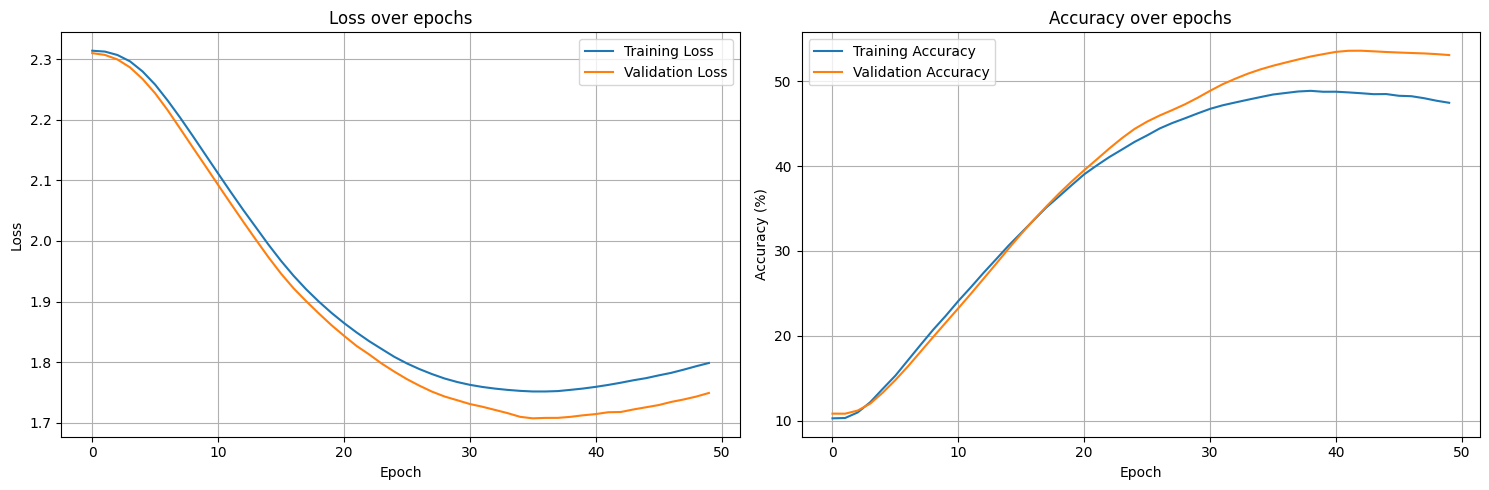

In [53]:
# Initialize model
model = EEGClassifier(
    input_channels=1,
    num_classes=num_classes,
    dropout_prob=0.3
)

# Train with smaller batch size for stability
train_loader = DataLoader(
    train_dataset,
    batch_size=16,  # Reduced batch size
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,  # Reduced batch size
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

# Train model
trained_model, train_losses, val_losses, train_accs, val_accs = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=50
)